# Local Training 

Creating image similarity model...


 10%|█         | 3/30 [00:00<00:01, 20.45it/s]

Reading images from %s... ../data/train


100%|██████████| 30/30 [00:00<00:00, 39.29it/s]


Training similarity model...
Training completed. Registering model...


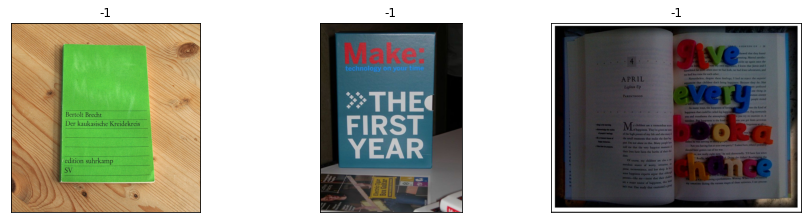

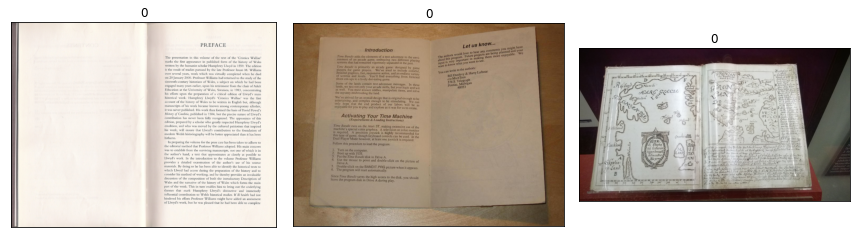

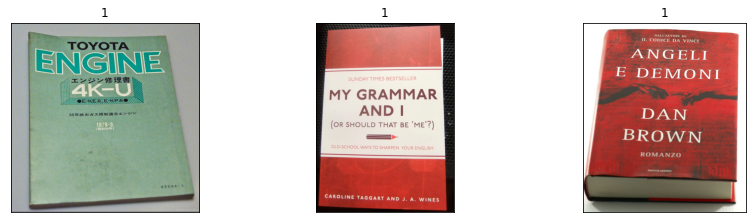

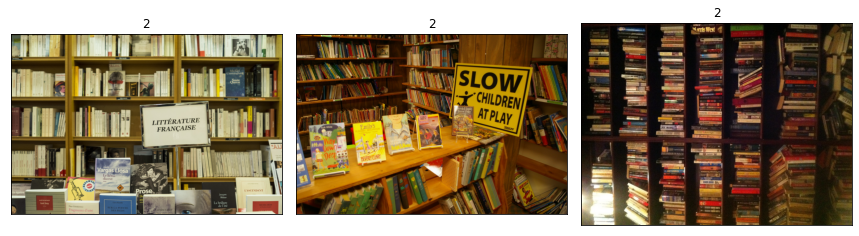

In [7]:
import sys
sys.path.append("../")
import logging
import tempfile
import os
import argparse
from os.path import join
import random
import joblib
import numpy as np
from ml.utils.image import read_images_from_list, show_images
import logging 
import matplotlib.pyplot as plt
import ipyplot

from ml.extractors.vgg16_extractor import VGG16Extractor
from ml.models.DBSCAN import DBSCANv2
from ml.similarity.detector import ImageSimilarityDetector
from ml.utils.image import read_images_from_folder

# General parameters
input_dir = "../data/train"
fraction = 1.0
model_name = "books"
metric = "cosine"
min_samples = 3
eps = 0.64
report_n_samples = 3
recursive = False

# Setup extractor, model and similarity detector 
print("Creating image similarity model...")
extractor = VGG16Extractor()
model = DBSCANv2(eps=eps, min_samples=min_samples, metric=metric)
detector = ImageSimilarityDetector(extractor, model)


# List the input folder
print("Reading images from %s...", input_dir)
files = []

for r, _, f in os.walk(input_dir):
    for file in f:
        files.append(join(r, file))
    if not recursive:
        break
# Randomly select fraction of images for training
files = random.sample(files, int(len(files) * fraction))
# Read images
images, _ = read_images_from_list(files)

# Training model
print("Training similarity model...")
labels = detector.train(images)

# Saving model
path = '/Users/shanepeckham/sources/azdoclustering/image-clustering-skill/find_similarity/score_similarity/models/'
print("Training completed. Registering model...")
file_name = f'{model_name}.pkl'
tags = {
    "min_samples": min_samples,
    "eps": eps,
    "metric": metric
}
joblib.dump(value=detector.model, filename=os.path.join(path, file_name))

# Saving clustering report
if not os.path.isdir(path):
    os.makedirs(os.path.join(path, 'report'))
else:
    cluster_ids = np.unique(labels)
    for cluster_id in cluster_ids:
        sub_images = images[labels == cluster_id]
        cluster = np.random.choice(sub_images, min(report_n_samples, len(sub_images)), replace=False)
        cluster_labels = [cluster_id] * len(cluster)
        fig = show_images(cluster, cols=4, titles=cluster_labels)
        fig.savefig(os.path.join(path, 'report', f'cluster_{cluster_id}_samples.png'))



# Create Azure Machine Learning training pipeline

This notebook shows the way how to create an AML pipeline for clustering model training. It consists of the following steps:
1. AML environment setup 
2. Pipeline configuration preparation 
3. Pipeline creation
4. Pipeline run

The training step will also register the resulting model in the AML workspace as an artifact. 

You will need to create a .env file here, see the file .env.example. 

It will need to contain the following:
```bash
    TENANT_ID=XXXXXX
    AML_BLOB_ACCOUNT_NAME=XXXXXX
    AML_BLOB_ACCOUNT_KEY=XXXXXX
```

In [9]:
%load_ext dotenv
%dotenv

import os
from os.path import join
import sys

sys.path.append("../")

import pandas as pd
import numpy as np

from azureml.core import Environment, Datastore, Workspace, Experiment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.data.data_reference import DataReference
from azureml.pipeline.core import Pipeline
from azureml.pipeline.steps import PythonScriptStep
from azureml.core.runconfig import RunConfiguration

from mlops.common.attach_compute import get_compute
from mlops.common.get_datastores import get_blob_datastore

cannot find .env file


In [ ]:
from azureml.core.authentication import InteractiveLoginAuthentication

interactive_auth = InteractiveLoginAuthentication(tenant_id=os.getenv("TENANT_ID"))

In [ ]:
# Restore AML workspace from config.json file (can be downloaded through the portal)

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

compute_target = get_compute(
    workspace=ws,
    compute_name="trainclust",
    vm_size='Standard_NC6',
    vm_priority='lowpriority', 
    min_nodes=0,
    max_nodes=4,
    scale_down=120
)

In [ ]:
# Get or register a datastore (blob with our data)
datastore = get_blob_datastore(ws, "data", os.getenv("AML_BLOB_ACCOUNT_NAME"), 
                               os.getenv("AML_BLOB_ACCOUNT_KEY"), "[your container]")

# Create input and output data references
# WARNING! DataReference works up to 12x times faster than Dataset for small files
img_dir = DataReference(
    datastore=datastore, 
    data_reference_name="books", 
    path_on_datastore="books",
    mode="mount"
)

In [ ]:
# Build task-specific environment

from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies

# Create Pipeline run configuration 

run_config = RunConfiguration()
run_config.environment.docker.enabled = True
run_config.environment.python.conda_dependencies = CondaDependencies.create(
    pip_packages=[
        'azureml-sdk==1.15.0',
        'numpy==1.18.5',
        'pandas==1.1.3',
        'pillow==7.2.0',
        'pyarrow==1.0.1',
        'scikit-image==0.17.2',
        'scikit-learn==0.23.2',
        'scipy==1.5.2',
        'tqdm==4.48.2',
        'opencv-python-headless',
        'tensorflow==2.3.0',
        'PyYAML==5.3.1'
    ]
)

In [ ]:
# Create Custom Vision scoring step

source_directory = '../'

train_step = PythonScriptStep(
    script_name="mlops/clustering_pipeline/steps/train.py", 
    arguments=[
        "--input_dir", img_dir,
        "--fraction", 1.0, # fraction of the dataset
        "--recursive", False,
        "--eps", 0.64,
        "--min_samples", 3,
        "--metric", "cosine",
        "--model_name", "dbscan_test"
    ],
    inputs=[img_dir],
    compute_target=compute_target, 
    source_directory=source_directory,
    runconfig=run_config
)

# Create pipeline using existing steps
train_pipeline = Pipeline(workspace=ws, steps=[train_step])

# Check if the pipeline is consistent 
train_pipeline.validate()

# Publish pipeline
published_pipeline = train_pipeline.publish(
    name = "similarity_train",
    description = "Pipeline to train a similarity model for a custom Azure Search skill"
)

In [ ]:
# Submit the pipeline
pipeline_run = Experiment(ws, 'similarity-train-exp').submit(train_pipeline)
pipeline_run.wait_for_completion()